# STL LaunchCode Women+ Final Project
by Hafsa and Nicole

In [1]:
# Dependencies and modules:

import numpy as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import pprint as pp
import seaborn as sns
import requests
import json
import html
import statistics
import psycopg2
import itertools

from numpy import vstack
from scipy.stats import randint

from statsmodels.formula.api import ols, logit
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedKFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import IsolationForest
from torch import Tensor
from torch.nn import Linear
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD, Adam
from torch.nn import MSELoss
from torch.nn.init import xavier_uniform_
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from api import my_api
from passwords import my_password

# Audible cell-completion notification:
from IPython.display import Audio
Audio('Bicycle-bell.mp3', autoplay=True)

## API Call to Federal Census Database for American Community Survey 5-Year Data (2009-2019)

We want to identify geographic locations that represent the poorest and most affluent populations. To do this, we will isolate data for % Below Poverty and % with income > $100k per year ($90k per year is the lowest state figure to put a household in the top 20% of earners for that state. $100k represents the closest census income bracket to that value.)

In [2]:
# define api key:
api_key = my_api

# define api base url for :
base_url_pov = 'https://api.census.gov/data/2019/acs/acs5/profile?get=group(DP03)&for=county:*&in=state:*' 
# create response object from an api call request:
req1 = requests.get(base_url_pov)
print(req1)  # response 200!

pov_data = req1.json()
Audio('Bicycle-bell.mp3', autoplay=True)

<Response [200]>


In [3]:
poverty = pd.DataFrame(pov_data)
# Setting first row as header:
poverty.columns = poverty.iloc[0] 
# Pulling header out of dataframe:
poverty = poverty[1:]
# Checking results:
poverty.head(2)

,DP03_0001E,DP03_0001EA,DP03_0001M,DP03_0001MA,DP03_0001PE,DP03_0001PEA,DP03_0001PM,DP03_0001PMA,DP03_0002E,DP03_0002EA,...,DP03_0137M,DP03_0137MA,DP03_0137PE,DP03_0137PEA,DP03_0137PM,DP03_0137PMA,GEO_ID,NAME,state,county
1,17630,None,131,None,17630,None,-888888888,(X),9285,None,...,-888888888,(X),27.2,None,4.5,None,0500000US17051,"Fayette County, Illinois",17,051
2,24117,None,83,None,24117,None,-888888888,(X),13168,None,...,-888888888,(X),20.6,None,3.3,None,0500000US17107,"Logan County, Illinois",17,107


## Census Data Feature Selection and Engineering

### Creating dictionary of variable definitions:

The columns from the Census API are not intuitively labeled. To give context to the data, we will pull definitions of each column label from a Census website variable table document and incorporate that into our dataframe.

In [4]:
# Displaying variable labels to determine features to keep. Downloaded varables .csv 
# from census.gov:

var_df = pd.read_csv("variable_names.csv")
the_vars = var_df.T

pd.set_option("display.max.rows", None)
pd.set_option('display.max_colwidth', None)
the_vars = the_vars.reset_index()


# adding state and county variable definitions:
state = {'index':'state', 0 : 'state id'}
county = {'index': 'county', 0 : 'county id'}

# var_defs = the_vars.append(state, ignore_index=True, sort=False)
var_defs = pd.concat([the_vars, pd.DataFrame(state, index=[0])], ignore_index=True, sort=False)
# var_defs = var_defs.append(county, ignore_index=True, sort=False)
var_defs = pd.concat([var_defs, pd.DataFrame(county, index=[0])], ignore_index=True, sort=False)

# Removing "margin of error" and "percent margin of error" rows:
vars = var_defs[var_defs["index"].str.contains("PE") == True]
geo = var_defs.iloc[np.r_[548:550, 552:554]]
our_vars = pd.concat([vars,geo])
our_vars = our_vars.reset_index(drop=True)

# we want to keep rows concerning "% of All People Below poverty level", row 127
# and rows concerning Income and Benefits 100,000 to 200,000+, rows 82-84
# and rows with geo info, 138-140:
our_vars = our_vars.iloc[np.r_[82:85, 127:128, 138:141]]
our_var_defs = our_vars[['index', 0]]
our_var_defs

,index,0
82,DP03_0083PE,"Percent!!INCOME AND BENEFITS (IN 2010 INFLATION-ADJUSTED DOLLARS)!!$100,000 to $149,999"
83,DP03_0084PE,"Percent!!INCOME AND BENEFITS (IN 2010 INFLATION-ADJUSTED DOLLARS)!!$150,000 to $199,999"
84,DP03_0085PE,"Percent!!INCOME AND BENEFITS (IN 2010 INFLATION-ADJUSTED DOLLARS)!!$200,000 or more"
127,DP03_0128PE,Percent!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people
138,NAME,Geographic Area Name
139,state,state id
140,county,county id


### Using the index column from variables dataframe to slice for rows in the poverty dataframe, then join the two:

In [5]:
# use definitions to identify data columns to keep:
columns_to_keep = our_var_defs['index'].to_list()
our_poverty = poverty[columns_to_keep]

# a dtype check shows all columns to be object type. 
# cast intuitively numeric columns as numeric:
our_pov = our_poverty.copy()
our_pov[['DP03_0083PE', 'DP03_0084PE', 'DP03_0085PE', 'DP03_0128PE']] = our_pov[['DP03_0083PE', 'DP03_0084PE', 'DP03_0085PE', 'DP03_0128PE']].apply(pd.to_numeric)

# # # Sort by State:
op = our_pov.copy()
op = op.sort_values('state').reset_index(drop=True)
poverty_df = op.copy()

# Index reset:
poverty_df = poverty_df.reset_index(drop=True)
# Remove ' County' from NAME column:
names = list(poverty_df['NAME'])
names_fixed = []
for string in names:
    new_names = string.replace(" County", "")
    caps_names = new_names.upper()
    names_fixed.append(caps_names)

poverty_df['Names_Fixed'] = names_fixed
poverty_df.head()

,DP03_0083PE,DP03_0084PE,DP03_0085PE,DP03_0128PE,NAME,state,county,Names_Fixed
0,12.7,0.4,2.6,28.9,"Bullock County, Alabama",01,011,"BULLOCK, ALABAMA"
1,9.3,3.5,1.9,19.4,"Fayette County, Alabama",01,057,"FAYETTE, ALABAMA"
2,14.7,5.5,3.2,23.2,"Clarke County, Alabama",01,025,"CLARKE, ALABAMA"
3,15.7,4.7,3.1,17.9,"Calhoun County, Alabama",01,015,"CALHOUN, ALABAMA"
4,12.8,2.4,3.1,18.1,"Bibb County, Alabama",01,007,"BIBB, ALABAMA"


### We now want to find the three poorest counties and three wealthiest counties per state that we can then match with county-level drinking water violation reports from the EPA.

Steps we will take:
1.  Sum values for income >100k columns, then drop original columns
2. Sort by state, sort by county, aggregate .nhighest(3) for data columns 

In [6]:
# Create new column to sum income bracket columns and drop originals:
numpov = poverty_df.copy()
numpov['% Wealthy'] = numpov[['DP03_0083PE','DP03_0084PE','DP03_0085PE']].sum(numeric_only=True, axis=1)
numpov['% Impoverished'] = numpov['DP03_0128PE']

# rename and reorganize columns
pov_final = numpov[['Names_Fixed', 'state', 'county', '% Wealthy','% Impoverished']]

#sort to get 3 poorest and 3 wealthiest:
#sort to get 3 poorest and 3 wealthiest:
income= pov_final.groupby('state',as_index=False).apply(lambda x: x.nlargest(3, '% Wealthy')[['Names_Fixed','% Wealthy','% Impoverished','state','county']])
poverty = pov_final.groupby('state',as_index=False).apply(lambda x: x.nlargest(3, '% Impoverished')[['Names_Fixed','% Wealthy','% Impoverished','state','county']])
poverty_df = pd.DataFrame(poverty)
income_df = pd.DataFrame(income)

# merge the dataframes then split 'Names_Fixed' into county and state:
wealthy_v_poor = pd.merge(income, poverty, how='outer', sort=True)
wealthy_v_poor[['County','State']] = wealthy_v_poor['Names_Fixed'].str.split(', ', expand=True)

# Organize and sort:
wealthy_v_poor = wealthy_v_poor[['State','County','% Wealthy','% Impoverished']].sort_values(['State', '% Wealthy'],ascending=[True,False])
wealthy_v_poor = wealthy_v_poor.reset_index(drop=True)
wealthy_v_poor.head()

,State,County,% Wealthy,% Impoverished
0,ALABAMA,SHELBY,47.3,7.5
1,ALABAMA,MADISON,42.8,12.5
2,ALABAMA,BALDWIN,34.8,10.4
3,ALABAMA,PERRY,16.4,30.8
4,ALABAMA,SUMTER,14.9,31.8


Now we are ready to pull drinking water reports for the counties concerned.

## API Call to Federal Environmental Protection Agency Safe Drinking Water Information System (2009-2019)

In [7]:
# base url for epa.gov SDWIS:
base_url_wat = ' https://enviro.epa.gov/enviro/efservice/SDW_VIOL_ENFORCEMENT/COUNTYSERVED/'

# taking a random county in New York state as a test case:
county= 'CHAUTAUQUA'
state_abbr= 'NY'

req2 = requests.get(base_url_wat+ f'{county}/STATE/{state_abbr}/JSON')
print(req2)  # response 200!

#creating a json output of the request object:
ny_water = req2.json()

<Response [200]>


In [8]:
# examining json to understand structure for more precise API calls:
ny_water

[{'PWSID': 'NY0600363',
  'PWSNAME': 'HANOVER WD #3 - FORESTVILLE',
  'STATE': 'NY',
  'COUNTYSERVED': 'CHAUTAUQUA',
  'VIOID': 916,
  'CCODE': 2950,
  'CNAME': 'TTHM',
  'CTYPE': 'Not Regulated',
  'VCODE': 27,
  'VNAME': 'Monitoring and Reporting (DBP)',
  'VTYPE': 'MR',
  'VIOLMEASURE': 'Monitoring and Reporting',
  'ENFACTIONTYPE': 'SFM',
  'ENFACTIONNAME': 'St Admin Penalty assessed',
  'ENFDATE': '31-DEC-12',
  'COMPPERBEGINDATE': '01-OCT-12',
  'COMPPERENDDATE': '31-DEC-12',
  'SOURCES': 'Byproduct of drinking water disinfection',
  'DEFINITION': 'Trihalomethanes occur when naturally-occurring organic and inorganic materials in the water react with the disinfectants, chlorine and chloramine.',
  'HEALTH_EFFECTS': 'Liver, kidney or central nervous system problems; increased risk of cancer'},
 {'PWSID': 'NY0600363',
  'PWSNAME': 'HANOVER WD #3 - FORESTVILLE',
  'STATE': 'NY',
  'COUNTYSERVED': 'CHAUTAUQUA',
  'VIOID': 916,
  'CCODE': 2950,
  'CNAME': 'TTHM',
  'CTYPE': 'Not Regula

In [9]:
# creating a dataframe of the SDWIS report to examine available data:
ny_df = pd.DataFrame(ny_water)
ny_df.head()

,PWSID,PWSNAME,STATE,COUNTYSERVED,VIOID,CCODE,CNAME,CTYPE,VCODE,VNAME,VTYPE,VIOLMEASURE,ENFACTIONTYPE,ENFACTIONNAME,ENFDATE,COMPPERBEGINDATE,COMPPERENDDATE,SOURCES,DEFINITION,HEALTH_EFFECTS
0,NY0600363,HANOVER WD #3 - FORESTVILLE,NY,CHAUTAUQUA,916,2950,TTHM,Not Regulated,27,Monitoring and Reporting (DBP),MR,Monitoring and Reporting,SFM,St Admin Penalty assessed,31-DEC-12,01-OCT-12,31-DEC-12,Byproduct of drinking water disinfection,"Trihalomethanes occur when naturally-occurring organic and inorganic materials in the water react with the disinfectants, chlorine and chloramine.","Liver, kidney or central nervous system problems; increased risk of cancer"
1,NY0600363,HANOVER WD #3 - FORESTVILLE,NY,CHAUTAUQUA,916,2950,TTHM,Not Regulated,27,Monitoring and Reporting (DBP),MR,Monitoring and Reporting,SIF,St Public Notif received,01-MAY-13,01-OCT-12,31-DEC-12,Byproduct of drinking water disinfection,"Trihalomethanes occur when naturally-occurring organic and inorganic materials in the water react with the disinfectants, chlorine and chloramine.","Liver, kidney or central nervous system problems; increased risk of cancer"
2,NY0600363,HANOVER WD #3 - FORESTVILLE,NY,CHAUTAUQUA,912,1040,Nitrate,Nitrates,03,"Monitoring, Regular",MR,Monitoring and Reporting,SIE,St Public Notif requested,25-JAN-13,01-JAN-12,31-DEC-12,"Runoff from fertilizer use; leaking from septic tanks, sewage; erosion of natural deposits","Nitrates and nitrites are nitrogen-oxygen chemical units which combine with various organic and inorganic compounds. The greatest use of nitrates is as a fertilizer. Once taken into the body, nitrates are converted to nitrites.","Infants below the age of six months who drink water containing nitrite in excess of the MCL could become seriously ill and, if untreated, may die. Symptoms include shortness of breath and blue-baby syndrome."
3,NY0600363,HANOVER WD #3 - FORESTVILLE,NY,CHAUTAUQUA,914,2950,TTHM,St1 DBP,27,Monitoring and Reporting (DBP),MR,Monitoring and Reporting,SIE,St Public Notif requested,31-DEC-12,01-JUL-12,30-SEP-12,Byproduct of drinking water disinfection,"Trihalomethanes occur when naturally-occurring organic and inorganic materials in the water react with the disinfectants, chlorine and chloramine.","Liver, kidney or central nervous system problems; increased risk of cancer"
4,NY0600363,HANOVER WD #3 - FORESTVILLE,NY,CHAUTAUQUA,920,1040,Nitrate,Nitrates,03,"Monitoring, Regular",MR,Monitoring and Reporting,SFM,St Admin Penalty assessed,16-JAN-16,01-JAN-15,31-DEC-15,"Runoff from fertilizer use; leaking from septic tanks, sewage; erosion of natural deposits","Nitrates and nitrites are nitrogen-oxygen chemical units which combine with various organic and inorganic compounds. The greatest use of nitrates is as a fertilizer. Once taken into the body, nitrates are converted to nitrites.","Infants below the age of six months who drink water containing nitrate in excess of the MCL could become seriously ill and, if untreated, may die. Symptoms include shortness of breath and blue-baby syndrome."


## Process for finding target variable:

After careful consideration of the data available, it seemed most reasonable to use the number of drinking water violations reported per county within our date range as the best marker of a geographic area's drinking water quality.

Even further, it is necessary to group contaminant analytes into analytical groups to avoid counting a single violation many times. See the process we used below:

In [10]:
# Here we have the counts for each violation recorded for the county.
cname_totals = ny_df['CNAME'].value_counts()
cname_totals

Coliform (TCR)                   1016
Nitrate                           610
Total Haloacetic Acids (HAA5)      90
TTHM                               84
Arsenic                            55
cis-1,2-Dichloroethylene           36
DICHLOROMETHANE                    36
p-Dichlorobenzene                  36
1,1,1-Trichloroethane              36
Tetrachloroethylene                36
Ethylbenzene                       36
1,1,2-Trichloroethane              36
Styrene                            36
1,1-Dichloroethylene               36
Benzene                            36
Carbon tetrachloride               36
Trichloroethylene                  36
1,2-Dichloroethane                 36
Vinyl chloride                     36
1,2,4-Trichlorobenzene             36
1,2-Dichloropropane                36
o-Dichlorobenzene                  36
trans-1,2-Dichloroethylene         36
CHLOROBENZENE                      36
Toluene                            36
Radium-228                         16
Radium-226  

In [11]:
# Notice, however, that many of the above numbers are identical. That is because,
# chemically, these contaminants tend to be found together. It is more meaningful,
# then, to not count the violation per individual analytes, but by analyte groups.
# Here we find the set of unique analyte group violations:
unique_viols = ny_df['CNAME'].value_counts().unique()
unique_viols

array([1016,  610,   90,   84,   55,   36,   16,    6], dtype=int64)

In [12]:
# Now we can find the total of those and get a good measure of water quality:
total_viols = sum(ny_df['CNAME'].value_counts().unique())
total_viols

1913

## Crafting an API call to gather desired data:

While we have determined what our target variable will be, we still want to pull enough other data from the API to provide context for our results. We decided on a set of features we would like to pull from the API and how we wish to iterate through that data to compile a meaningful dataset.

In [13]:
# Create lists of counties for each state
counties_gb = wealthy_v_poor.groupby('State')['County']
groups = dict(list(counties_gb))
counties_list = []
def county_lists():
    for state in groups:
        counties = groups[state].to_list()
        counties_list.append(counties)
county_lists()

# Creating a dictionary of states and county lists:
states = pd.read_csv('state_fips.csv')
abrv = states['Abrv'].unique()
counties_dict = {}
def county_dict():
    for key in abrv:
        for value in counties_list:
            counties_dict[key] = value
            counties_list.remove(value)
            break 
county_dict()

In [14]:
# shortening counties_dict:
new_dict = dict(itertools.islice(counties_dict.items(), 10))
new_dict

{'AL': ['SHELBY', 'MADISON', 'BALDWIN', 'PERRY', 'SUMTER', 'GREENE'],
 'AK': ['JUNEAU CITY AND BOROUGH',
  'DENALI BOROUGH',
  'ANCHORAGE MUNICIPALITY',
  'NORTHWEST ARCTIC BOROUGH',
  'BETHEL CENSUS AREA',
  'KUSILVAK CENSUS AREA'],
 'AZ': ['MARICOPA', 'COCONINO', 'PIMA', 'NAVAJO', 'SANTA CRUZ', 'APACHE'],
 'AR': ['BENTON', 'SALINE', 'PULASKI', 'CHICOT', 'PHILLIPS', 'DESHA'],
 'CA': ['MARIN', 'SAN MATEO', 'SANTA CLARA', 'FRESNO', 'TULARE', 'IMPERIAL'],
 'CO': ['DOUGLAS', 'BROOMFIELD', 'BOULDER', 'COSTILLA', 'BENT', 'CROWLEY'],
 'CT': ['TOLLAND',
  'FAIRFIELD',
  'MIDDLESEX',
  'HARTFORD',
  'NEW HAVEN',
  'WINDHAM'],
 'DE': ['NEW CASTLE', 'SUSSEX', 'KENT'],
 'FL': ['DISTRICT OF COLUMBIA'],
 'GA': ['ST. JOHNS', 'MONROE', 'COLLIER', 'HAMILTON', 'MADISON', 'DESOTO']}

#### Testing api call:

In [15]:
# testing
ala_dict={'AL':['SHELBY', 'MADISON', 'BALDWIN', 'PERRY', 'SUMTER', 'GREENE']}

ala_contaminants = {'State': [], 
               'County': [], 
               'Contaminant Name': [],}
for key in ala_dict:
    
    for value in ala_dict[key]:
        base_url_wat = 'https://enviro.epa.gov/enviro/efservice/SDW_VIOL_ENFORCEMENT/COUNTYSERVED/'

        try:
            req2 = requests.get(base_url_wat+ f'{value}/STATE/{key}/JSON')
            data = req2.json()
            try:
                # Getting the state:
                for entry in data[0]:
                    state = data[0]['STATE']
                    ala_contaminants['State'].append(state)
                    # Getting the county:
                    county = data[0]['COUNTYSERVED']
                    ala_contaminants['County'].append(county)
                    # Getting the cname:
                    name = data[0]['CNAME']
                    ala_contaminants['Contaminant Name'].append(name)

            except Exception as e:
                print(e)

        except:
            pass

data_f = pd.DataFrame({k:pd.Series(v) for k,v in ala_contaminants.items()})
data_f.head(10)        

,State,County,Contaminant Name
0,AL,SHELBY,Total Haloacetic Acids (HAA5)
1,AL,SHELBY,Total Haloacetic Acids (HAA5)
2,AL,SHELBY,Total Haloacetic Acids (HAA5)
3,AL,SHELBY,Total Haloacetic Acids (HAA5)
4,AL,SHELBY,Total Haloacetic Acids (HAA5)
5,AL,SHELBY,Total Haloacetic Acids (HAA5)
6,AL,SHELBY,Total Haloacetic Acids (HAA5)
7,AL,SHELBY,Total Haloacetic Acids (HAA5)
8,AL,SHELBY,Total Haloacetic Acids (HAA5)
9,AL,SHELBY,Total Haloacetic Acids (HAA5)


In [16]:
# Creating an empty dictionary to store our api data:
contaminants = {'State': [], 
               'County': [], 
               'Contaminant Name': [],
               'Contaminant Type': [],
               'Enfaction Date': [],
               'Sources': [],
               'Definition': [],
               'Health Effects': []}


for key in new_dict:
    for value in new_dict[key]:
        base_url_wat = ' https://enviro.epa.gov/enviro/efservice/SDW_VIOL_ENFORCEMENT/COUNTYSERVED/'

        try:
            req2 = requests.get(base_url_wat+ f'{value}/STATE/{key}/JSON')
            data = req2.json()
            data_list = dict(itertools.islice(data[0].items(), 1000))

            try:
                for entry in data_list:
                    
                    # Getting the state:
                    state = data[0]['STATE']
                    contaminants['State'].append(state)
                    
                    # Getting the county:
                    county = data[0]['COUNTYSERVED']
                    contaminants['County'].append(county)
                    
                    # Getting the cname:
                    name = data[0]['CNAME']
                    contaminants['Contaminant Name'].append(name)

                    # Getting the ctype:
                    type = data[0]['CTYPE']
                    contaminants['Contaminant Type'].append(type)

                    # Getting the edate:
                    date = data[0]['ENFDATE']
                    contaminants['Enfaction Date'].append(date)

                    # Getting the sources:
                    source = data[0]['SOURCES']
                    contaminants['Sources'].append(source)

                    # Getting the definition:
                    defs = data[0]['DEFINITION']
                    contaminants['Definition'].append(defs)

                    # Getting the health:
                    effects = data[0]['HEALTH_EFFECTS']
                    contaminants['Health Effects'].append(effects)             

            except Exception as e:
                print(e)

        except:
            pass

violation_df = pd.DataFrame({k:pd.Series(v) for k,v in contaminants.items()})
violation_df.set_index("State",inplace=True)     
violation_df
Audio('Bicycle-bell.mp3', autoplay=True)

In [ ]:
# Getting columns for county and violation sums:
viols = violation_df.groupby('County')['CNAME'].agg(pd.Series.nunique, pd.Series.count, 'sum')
viols

In [ ]:
viols_df = pd.DataFrame(viols)
viols_df.rename(columns = {'CNAME':'Violations'})
viols_df

In [ ]:
# Pulling counties out of df:
counties = violation_df['County'].unique()
counties

In [ ]:
# creating a new df:
county_viols = pd.concat([counties,viols_df])
county_viols

In [ ]:
# Creating a violation reference dataframe to aid understanding:
reference_df = violation_df[['Contaminant Name','Sources','Definition','Health Effects']]
reference_df = reference_df.drop_duplicates(subset= 'Contaminant Name', inplace=True)
reference_df

## Combine census data with water data:

In [ ]:
# join the dataframes:
dw_qual = pd.merge(wealthy_v_poor, county_viols, on='County', sort=True)
dw_qual

In [ ]:
# Removing rows where we have no water data:
dw_qual = dw_qual.dropna()
dw_qual

## We now have viable datasets. We can store them in a SQL database for convienient examination and manipulation.

#### Transfering the organized data from python to PostgreSQL database with a psycopg2 connection:

In [ ]:
# remove commas from dataframes to avoid errors when converting to .csv:
violation_nocomma = violation_df.str.replace(', ', '')
violation_nocomma

In [ ]:
# remove commas from dataframes to avoid errors when converting to .csv:
reference_nocomma = reference_df.str.replace(', ', '')
reference_nocomma

In [ ]:
# convert all DataFrames into .csv files for loading into Postgres:
wealthy_v_poor.to_csv('wealthy_v_poor.csv', index= False)
violation_df.to_csv('violation_df.csv', index= False)
dw_qual.to_csv('dw_qual.csv', index= False)
reference_df.to_csv('reference_df.csv', index=False)

In [ ]:
#in PostgreSQL, create a new database named Final_Project to add new table to, and use psycopg2 to connect to it:
conn = psycopg2.connect(dbname='project_2', user='postgres', password=my_password)
#create a cursor object to perform database operations
cursor= conn.cursor()

#### Create a series of queries to create and populate database tables:

In [ ]:
#command to create a table
cursor.execute("DROP TABLE IF EXISTS wealthy_v_poor")
table1=("""CREATE TABLE wealthy_v_poor(
	State text,
	County text,
	% Wealthy float,
    % Impoverished float
    )""")
#execute command
cursor.execute(table1)

In [ ]:
#use copy from to input values from csv into postgres table
with open('wealthy_v_poor.csv', 'r') as f:
    next(f) # Skip the header row.
    cursor.copy_from(f, 'wealthy_v_poor', sep=',')

In [ ]:
#commit the table
conn.commit()

In [ ]:
cursor.execute("DROP TABLE IF EXISTS violation_df")
table2=("""CREATE TABLE violation_df(
	State text,
	County text,
    Contaminant Name text,
    Enfaction Date varchar,
    Sources text,
    Definition text,
	Health Effects text
    )""")
cursor.execute(table2)

In [ ]:
with open('violation_df.csv', 'r') as f:
    next(f)
    cursor.copy_from(f, 'violation_df', sep=',')

In [ ]:
conn.commit()

In [ ]:
cursor.execute("DROP TABLE IF EXISTS dw_qual")
table3=("""CREATE TABLE dw_qual(
	State text,
	County text,
	% Wealthy float,
    % Impoverished float,
    Violations int
    
    )""")
cursor.execute(table3)

In [ ]:
with open('dw_qual.csv', 'r') as f:
    next(f)
    cursor.copy_from(f, 'dw_qual', sep=',')

conn.commit()

In [ ]:
cursor.execute("DROP TABLE IF EXISTS reference_df")
table4=("""CREATE TABLE reference_df(
	Contaminant Name text,
	Sources text,
	Definition text,
    Health Effects text
    )""")
cursor.execute(table4)

In [ ]:
with open('reference_df.csv', 'r') as f:
    next(f)
    cursor.copy_from(f, 'reference_df', sep=',')

conn.commit()

### Our python data has been extracted, transformed, and loaded into a SQL database within PostgreSQL.
### The data can now be explored with SQL queries executed in python.

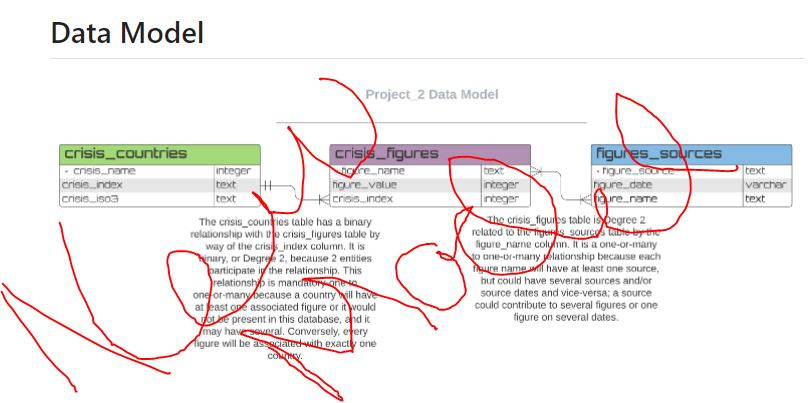

# Modeling the data and making predictions:

This is a straightforward dataset, so we want to see how well a basic regressions model works. We will use Multiple Linear Regression. However, there could be some sublte interplay between the variables that isn't immediately apparent, so we also want to see how a neural network performs. We will use a Keras regression model.

In [ ]:
# We want to take a peek at the kind of correlation we have:
for_modeling = dw_qual['% Wealthy','% Impoverished', 'Violations']
correlation = for_modeling.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(18,12))
sns.heatmap(correlation, annot=True, cmap="viridis")
ax.set_title('Correlation between Wealth, Poverty, and Drinking Water Quality')

### Preprocessing:

In [ ]:
# Before we use regression, we want to check the variance on our dataset:
dw_qual.var(numeric_only=True)
# Variance is pretty low across the dataset.

In [ ]:
# Drop non-numeric columns, then prepare our X and y:
X = dw_qual['% Wealthy','% Impoverished'].values
y = dw_qual['Violations'].values

# Split into training and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

# Multiple Linear Regression:

In [ ]:
# instantiate the classifier and fit the model:
lr = LinearRegression()
lr.fit(X_train, y_train)
# evaluate the model
y_pred= lr.predict(X_test)
y_pred

In [ ]:
# Evaluate the performance:
# root-squared error:
rsq = r2_score(y_test, y_pred)

# mean squared error
mse = mean_squared_error(y_test, y_pred)

print("MSE = "+str(mse))
print("R^2 value = "+str(rsq))

#### Plotting the regression:

In [ ]:
# To pass ndarrays to Seaborn, we make one dataset from them first:

# Converting two 1D arrays into a single 2D array:
one_array = np.column_stack((X_test,y_pred))

# Make a dataframe from the 2D array:
prediction_data = pd.DataFrame(one_array, columns=['test_poverty','pred_qual'])
prediction_data.head(2)

In [ ]:
#Plotting the data using sns:
plt.figure(figsize=(18,12))
sns.scatterplot(data=for_modeling, x='Violations', y='% Impoverished', hue='% Impoverished', palette='viridis', legend=False,edgecolor='slategray')
plt.title('Poverty vs. Drinking Water Quality')
plt.xlabel('Number of Violations')
plt.ylabel('% Citizens Impoverished in that County')

#Plotting the prediction:
sns.lineplot(data= prediction_data, x='test_poverty', y='pred_qual', legend='brief')
plt.legend(title='Multiple Linear Regression', loc='upper left', labels=['Predicted Quality','True Value'])
plt.show();

# Polynomial Regression:

In [ ]:
# instantiate my polynomial features object:
pn = PolynomialFeatures(degree = 2, include_bias=False)

#create new variables based off my previous t_t_s:
X_train_pn = pn.fit_transform(X_train)
X_test_pn = pn.fit_transform(X_test) 

# use linear regression on the model that should now have polynomial features:
pn.fit(X_train_pn,y_train)
lr_pn = LinearRegression()
lr_pn.fit(X_train_pn, y_train)

# create new y predictions with the X_test polynomials:
y_pn_pred = lr_pn.predict(pn.fit_transform(X_test))
y_pn_pred

In [ ]:
# Evaluate the model:
#R^2
pn_rsq = r2_score(y_test, y_pn_pred)

#mean squared error
pn_mse = mean_squared_error(y_test, y_pn_pred)

print("MSE = "+str(pn_mse))
print("R^2 value = "+str(pn_rsq))

In [ ]:
# Visualize the regression:
# Converting two 1D arrays into a single 2D array:
one_array = np.column_stack((X_test,y_pn_pred))

# Make a dataframe from the 2D array:
polynomial_data = pd.DataFrame(one_array, columns=['test_poverty','pn_pred_qual'])
polynomial_data.head(2)

In [ ]:
#Plotting the data using sns:
plt.figure(figsize=(18,12))
sns.scatterplot(data=for_modeling, x='Violations', y='% Impoverished', hue='% Impoverished', palette='viridis', legend=False,edgecolor='slategray')
plt.title('Poverty vs. Drinking Water Quality')
plt.xlabel('Number of Violations')
plt.ylabel('% Citizens Impoverished in that County')

#Plotting the prediction:
sns.lineplot(data= polynomial_data, x='test_poverty', y='pn_pred_qual', legend='brief')
plt.legend(title='Polynomial Regression', loc='upper left', labels=['Predicted Quality','True Value'])
plt.show();

# Modeling with PyTorch Neural Network:

In [ ]:
# using method from https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/

# Make the dataset into a Class with a torch function: 
class DW_Quality(Dataset):
    # load the dataset with a function: 
    def __init__(self, wq_path):
        # load the csv file as a dataframe
        water_q = pd.read_csv(wq_path, header=None)
        # store the inputs and outputs
        self.X = water_q.values[:, :-1].astype('float32')
        self.y = water_q.values[:, -1].astype('float32')
        # ensure target has the right shape
        self.y = self.y.reshape((len(self.y), 1))
 
    # setting number of rows in the dataset:
    def __len__(self):
        return len(self.X)
 
     # function to get a row at a particular index:
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    # function to get indexes for the train and test rows from random_split:
    def get_splits(self, n_test=0.33):
        # determine sizes, like, with math.
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        return random_split(self, [train_size, test_size])
    
# Audible cell-completion notification:
Audio('Bicycle-bell.mp3', autoplay=True)

In [ ]:
# defining the model:
class wq_MLP(Module):
    # choose elements for the model:
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # design first hidden layer:
        self.hidden1 = Linear(n_inputs, 10)
        # using the xavier_uniform_ torch function to set tensors
        xavier_uniform_(self.hidden1.weight)
        self.act1 = Sigmoid()
        # SECOND hidden layer:
        self.hidden2 = Linear(10, 8)
        xavier_uniform_(self.hidden2.weight)
        self.act2 = Sigmoid()
        # THIRD hidden layer and OUTPUT:
        self.hidden3 = Linear(8, 1)
        xavier_uniform_(self.hidden3.weight)
 
    # Forward propogation input:
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
         # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # third hidden layer and output
        X = self.hidden3(X)
        return X
    
# Audible cell-completion notification:
Audio('Bicycle-bell.mp3', autoplay=True)

In [ ]:
# Preparing the dataset:
def prepare_pp_data(wq_path):
    # load the dataset
    dataset = DW_Quality(wq_path)
    # get split:
    train, test = dataset.get_splits()
    # use data loaders:
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    test_dl = DataLoader(test, batch_size=1400, shuffle=False)
    return train_dl, test_dl
 
# train the model
def train_model(train_dl, wq_model):
    # choosing my optimization:
    criterion = MSELoss()
    optimizer = Adam(wq_model.parameters(), lr=0.01)
    # enumerate epochs
    for epoch in range(800):
        # enumerate mini batches
        torch_loss_values = list()
        for i, (inputs, targets) in enumerate(train_dl):
            # reset the gradients
            optimizer.zero_grad()
            # get output
            y_torch_pred = wq_model(inputs)
            # find loss
            loss = criterion(y_torch_pred, targets)
            # store final value:
            torch_loss_values.append(loss)
            # fire up backward propogation:
            loss.backward()
            # update model weights
            optimizer.step()
    torch_final_loss = torch_loss_values[-1]
    return torch_final_loss

# Audible cell-completion notification:
Audio('Bicycle-bell.mp3', autoplay=True)

In [ ]:
 # EVALUATE! :D
def evaluate_model(test_dl, wq_model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # run the test set!
        y_torch_pred = wq_model(inputs)
        # generate an array
        y_torch_pred = y_torch_pred.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # store in the lists:
        predictions.append(y_torch_pred)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # Get metrics:
    torch_rmse = np.sqrt(mean_squared_error(actuals, predictions))
    return torch_rmse

# Audible cell-completion notification:
Audio('Bicycle-bell.mp3', autoplay=True)

In [ ]:
# CALLING ALL FUNCTIONS! ALL ABOARD! LEAVING THE STATION!:

wq_path = 'dw_qual.csv'
train_dl, test_dl = prepare_data(wq_path)

# define the network
wq_model = MLP(5)

# train the model
train_model(train_dl, wq_model)

# evaluate the model
torch_rmse = evaluate_model(test_dl, wq_model)
torch_final_loss = train_model(train_dl, wq_model)
print('RMSE: %.4f, Loss: %.5f' % (torch_rmse, torch_final_loss))

# Audible cell-completion notification:
Audio('Bicycle-bell.mp3', autoplay=True)

# Conclusions:

conclusion, conslusion, yep, yep

We know we avoided overfitting or underfitting because ....